<a id='EDA'></a>

# Restaurant Fake Review Detection # 2

- __Exploratory Data Analysis__

<a id='EDA'></a>

# Exploratory Data Analysis

Please note that this EDA notebook contains plotly interactive plots which are not shown in this file as GitHub does not render embedded HTML. Please check out this [link](https://nbviewer.jupyter.org/github/sjung-stat/Fake-Review-Detection/blob/main/Exploratory_Data_Analysis.ipynb#EDA) to see the full version of EDA. 

In [1]:
# Import libraries required for analysis
 
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob

In [2]:
import plotly.graph_objects as go
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
%matplotlib inline

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

In [3]:
df_join = pd.read_pickle("./org_df.pkl")

In [4]:
df_join.columns

Index(['date', 'reviewContent', 'rating', 'flagged', 'reviewerID',
       'reviewer_location', 'yelpJoinDate', 'reviewer_friendCount',
       'reviewer_reviewCount', 'reviewer_firstCount', 'reviewer_usefulCount',
       'reviewer_coolCount', 'reviewer_funnyCount', 'reviewer_complimentCount',
       'reviewer_tipCount', 'reviewer_fanCount', 'restaurant_reviewCount',
       'restaurant_rating', 'categories', 'PriceRange'],
      dtype='object')

In [5]:
def viz_cont(var, binwidth=1, kde=True, log_scale=False): 
    """
    Plot three histograms using a continuous feature
    1) histogram of a variable based on 'flagged'
    2) histogram of a variable using filtered reviews
    3) histogram of a variable using unfiltered reviews
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,7))
    sns.histplot(data=df_join, x=var, hue="flagged", binwidth = binwidth, log_scale=log_scale, 
             stat='probability', kde=kde, ax=ax1).set_title("Filtered & Unfiltered reviews")
    sns.histplot(data=df_join[df_join['flagged']=="Y"], binwidth = binwidth, x=var, log_scale=log_scale, 
             stat='probability', kde=kde, ax=ax2, color = 'orange').set_title("Filtered reviews")
    sns.histplot(data=df_join[df_join['flagged']=="N"], binwidth = binwidth, x=var, log_scale=log_scale, 
             stat='probability', kde=kde, ax=ax3).set_title("Unfiltered reviews")

In [6]:
def cat_crosstab_plot(var):
    """
    Get cross table of categorical feature based on 'flagged' and create a bar plot
    """
    
    CrosstabResult_perc = pd.crosstab(df_join[var], df_join['flagged']).apply(lambda r: r/r.sum(), axis=1)
    stacked = CrosstabResult_perc.stack().reset_index().rename(columns={0:'ratio'})
    sns.barplot(x=stacked[var], y=stacked['ratio'], hue=stacked['flagged'], palette="ch:.35")
    plt.xticks(rotation=90)

<AxesSubplot:xlabel='rating', ylabel='count'>

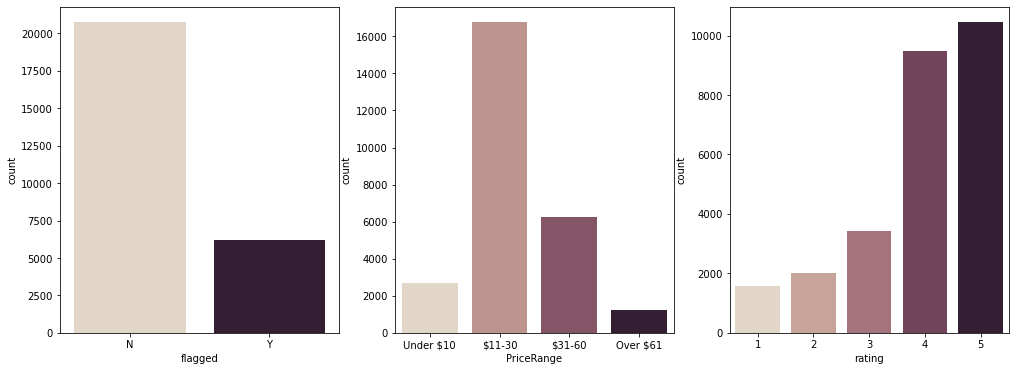

In [7]:
# Visualize the five categorical variables

col_names = ['flagged', 'PriceRange', 'rating', 'reviewer_location', 'categories']

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(17,6))
sns.countplot(x="flagged", palette="ch:.25", data=df_join, ax=ax1)
sns.countplot(x="PriceRange", palette="ch:.25", data=df_join, ax=ax2, order=['Under $10', '$11-30', '$31-60', 'Over $61'])
sns.countplot(x="rating", palette="ch:.25", data=df_join, ax=ax3)

<AxesSubplot:xlabel='count', ylabel='reviewer_location'>

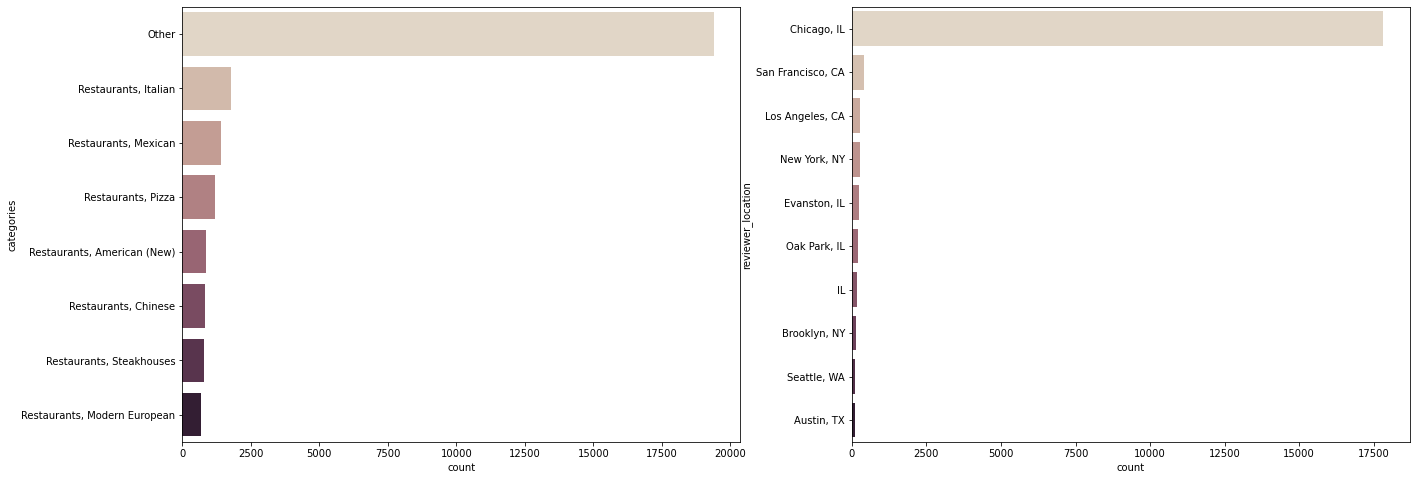

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(22,8))
sns.countplot(y="categories", data=df_join, palette="ch:.25",
              order=df_join.categories.value_counts().index, ax=ax1)
sns.countplot(y="reviewer_location", data=df_join, palette="ch:.25",
              order=df_join.reviewer_location.value_counts().iloc[:10].index, ax=ax2)


The ratio of filtered reviews vary by the category of restaurants. For instance, the 'Restaurants, American (New)' has very low ratio of filtered reviews, whereas the filtered ratio of 'Restaurants, Steakhouses' is much higher. 

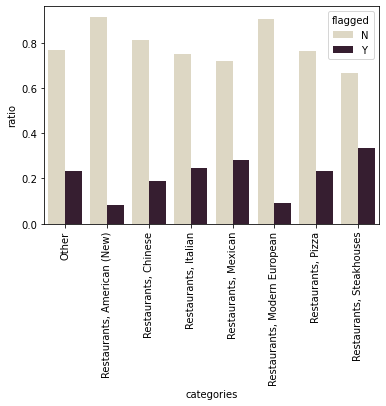

In [9]:
cat_crosstab_plot("categories")

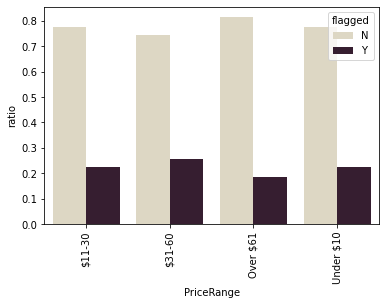

In [10]:
cat_crosstab_plot("PriceRange")

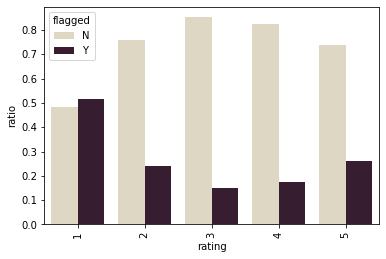

In [11]:
cat_crosstab_plot("rating")

The heatmap below shows how the continuous features are correlated with each other. 

<AxesSubplot:>

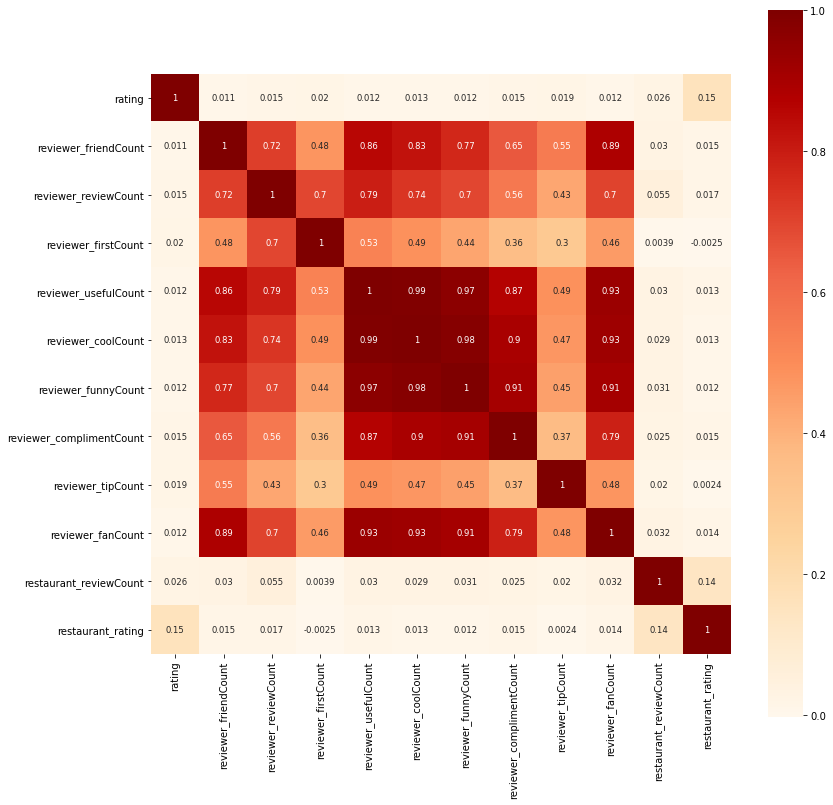

In [12]:
fig = plt.subplots(figsize=(13, 13))
sns.heatmap(df_join.corr(), annot = True, cbar = True, square = True, cmap="OrRd", annot_kws = {'size': 8.5})

Also, the 'reviewer_fanCount' and 'reviewer_friendCount' have a correlation of 0.89. Both of them represent the number of connections of each reviewer. The figure on the left shows that, even though the total number of filtered reviews is smaller than that of unfiltered reviews, more reviews written by reviewers without any friends (connection) were filtered.

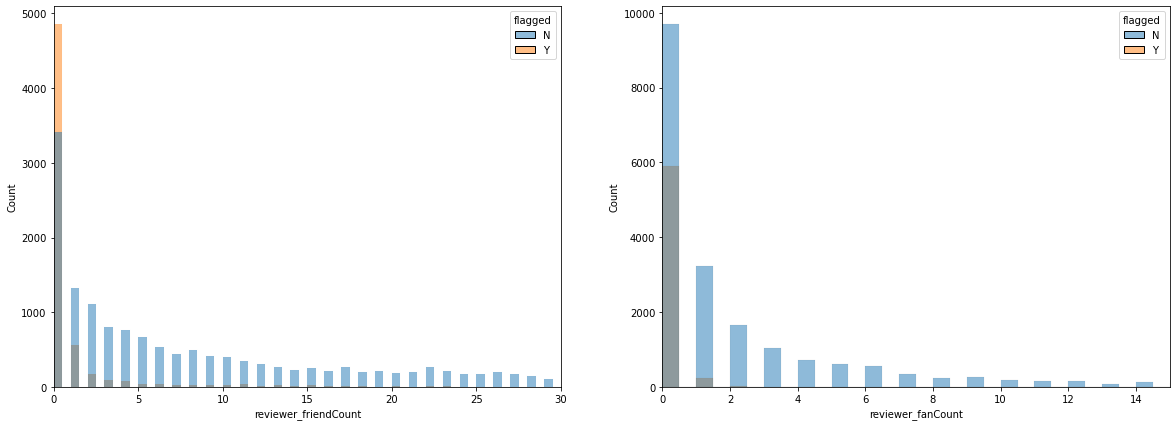

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,7))
sns.histplot(data=df_join, x="reviewer_friendCount", hue="flagged", binwidth=0.5, ax=ax1).axis(xmin=0, xmax=30)
sns.histplot(data=df_join, x="reviewer_fanCount", hue="flagged", binwidth=0.5, ax=ax2).axis(xmin=0, xmax=15)

plt.show()

Among the filtered reviews, the 'rating = 1' is the third most frequent level exceeding the probability of 0.1, whereas it is the least frequent one among the unfiltered reviews having the probability of less than 0.05. 

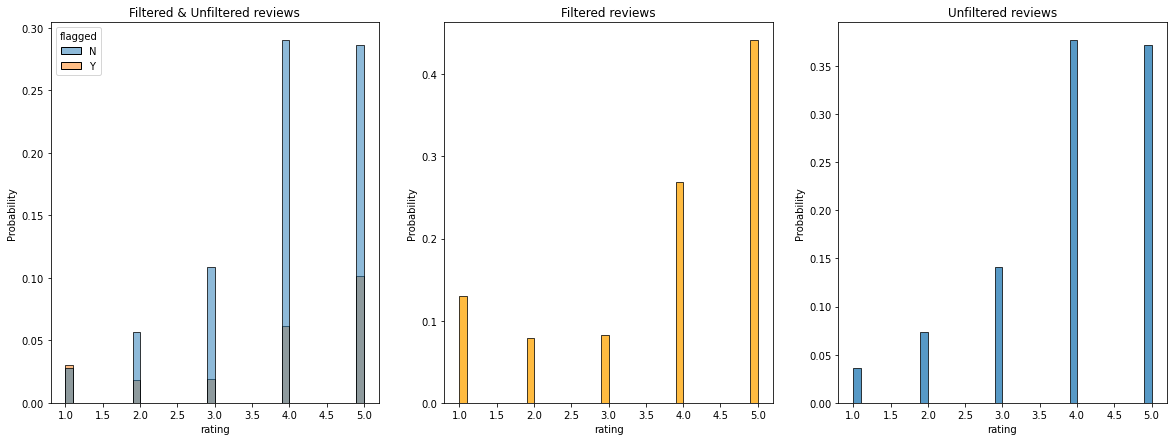

In [14]:
viz_cont("rating", binwidth=0.1, kde=False)

The distributions of reviewer_reviewCount of both filtered and unfiltered are highly skewed. After applying log transformation, the unfiltered reviews form a relatively bell-shaped (normal distribution-like) curve. On the other hand, the filtered reviews are still skewed. 

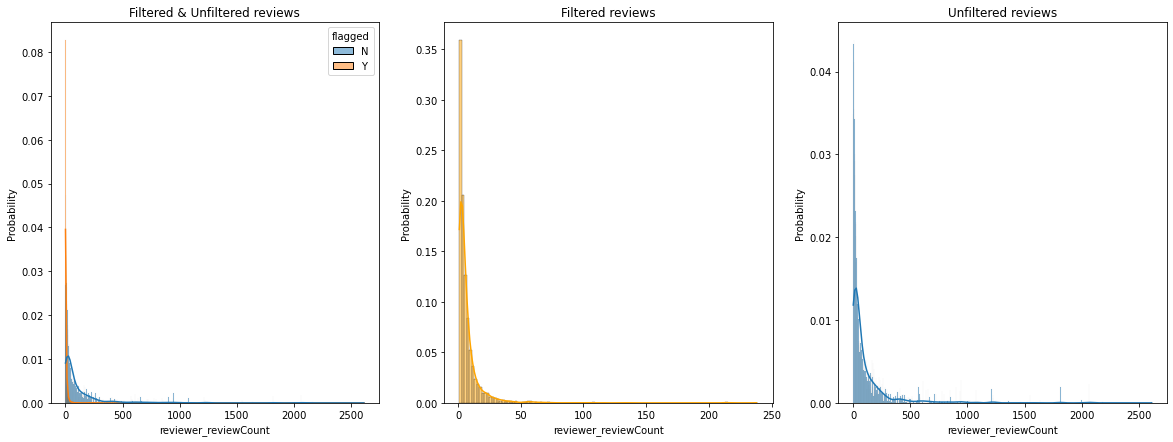

In [15]:
viz_cont("reviewer_reviewCount", binwidth=2)

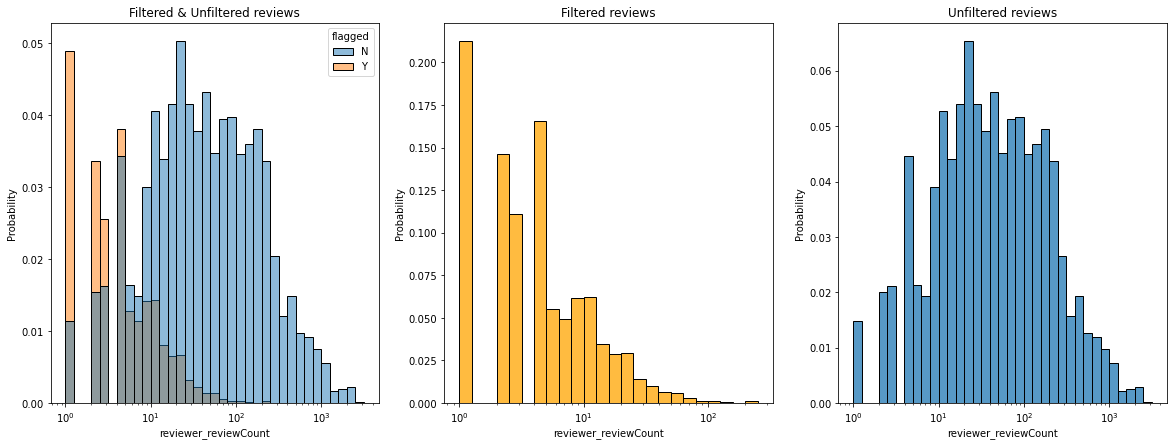

In [16]:
# Log transformed "reviewer_reviewCount"
viz_cont("reviewer_reviewCount", log_scale=True, kde=False, binwidth=0.1)

We use the 'date' feature to see if there is any pattern.  

In [17]:
# Create cross table based on 'date' and get year, month, day, weekday from the attribute 
date_flagged = pd.crosstab([df_join['date']], df_join['flagged'])
date_flagged.reset_index(level=0, inplace=True)

date_flagged['year'] = date_flagged.date.dt.year
date_flagged['month'] = date_flagged.date.dt.month
date_flagged['day'] = date_flagged.date.dt.day
date_flagged['weekday'] = date_flagged.date.dt.day_name()
date_flagged.head()

flagged,date,N,Y,year,month,day,weekday
0,2004-11-24,3,0,2004,11,24,Wednesday
1,2005-04-15,1,0,2005,4,15,Friday
2,2005-06-12,1,0,2005,6,12,Sunday
3,2005-07-02,1,0,2005,7,2,Saturday
4,2005-07-07,1,0,2005,7,7,Thursday


In [18]:
print("The reviews in the data were left between", date_flagged['date'].min(), "and", date_flagged['date'].max())

The reviews in the data were left between 2004-11-24 00:00:00 and 2012-09-23 00:00:00


#### Plotly Interactive Plots

The total counts of reviews increased roughly linearly until mid-2011 and decreased slightly afterwards. 

In [19]:
px.line(date_flagged, x='date', y=['N','Y'], labels={'x':'Date', 'y':'Count'},
       title='Filtered Vs. Unfiltered Review Count', range_x=['2004-11-24','2012-09-23'])

In [20]:
# Convert the dataframe into long format based on flagged. 
date_flagged_melt = pd.melt(date_flagged, id_vars=['date', 'year', 'month', 'day', 'weekday'], value_vars=['N', 'Y'])

# Sample data where reviews were left between 2006-09-01 and 2012-09-01 to balance out the month/weekday data
mask_2006_2012 = (date_flagged_melt['date'] >= '2006-09-01') & (date_flagged_melt['date'] <= '2012-09-01')

date_flagged_melt.head()

,date,year,month,day,weekday,flagged,value
0,2004-11-24,2004,11,24,Wednesday,N,3
1,2005-04-15,2005,4,15,Friday,N,1
2,2005-06-12,2005,6,12,Sunday,N,1
3,2005-07-02,2005,7,2,Saturday,N,1
4,2005-07-07,2005,7,7,Thursday,N,1


The box plot and bar plot below show the counts of reviews in each day of the week. People leave reviews on Monday the most (both the number of filtered and unfiltered reviews are the highest). Although the total counts of filtered reviews on Sunday, Monday, Tuesday, Wednesday are not significantly different, the total counts of unfiltered reviews are different. Considering the ratio of the number of filtered and unfiltered reviews, reviews left on Monday have much lower chance to be filtered, compared to Sunday, Tuesday, and Wednesday.

In [21]:
px.box(date_flagged_melt[mask_2006_2012], x='weekday', y='value', color='flagged', category_orders={"weekday": ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]})

In [22]:
px.bar(date_flagged_melt[mask_2006_2012], x='weekday', y='value', color='flagged', barmode='group', category_orders={"weekday": ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]})

The plots below show that the total counts of filtered reviews vary by the month. For instance, reviews were left the most on July and August. But the total counts drop significantly in September. And it significantly increases in January.

In [23]:
px.box(date_flagged_melt[mask_2006_2012], x='month', y='value', color='flagged')

In [24]:
px.bar(date_flagged_melt[mask_2006_2012], x='month', y='value', color='flagged', barmode='group')

In [25]:
# Create a 3D scatter plot using flight data
fig = px.scatter_3d(date_flagged, x='year', y='month', z='N', color='month',
                   opacity=0.7, width=800, height=400)
fig

This time, we use the 'yelpJoinDate' to see if there is any trend. 

In [26]:
# Create cross table based on 'yelpJoinDate' and get year, month from the attribute 
join_date_flagged = pd.crosstab([df_join['yelpJoinDate']], df_join['flagged'])
join_date_flagged.reset_index(level=0, inplace=True)

join_date_flagged['year'] = join_date_flagged.yelpJoinDate.dt.year
join_date_flagged['month'] = join_date_flagged.yelpJoinDate.dt.month

# Convert the dataframe into long format based on flagged. 
join_date_flagged_melt = pd.melt(join_date_flagged, id_vars=['yelpJoinDate', 'year', 'month'], value_vars=['N', 'Y'])
mask_2006_2012_join = (join_date_flagged_melt['yelpJoinDate'] >= '2006-09') & (join_date_flagged_melt['yelpJoinDate'] <= '2012-09')
join_date_flagged_melt.head()

,yelpJoinDate,year,month,flagged,value
0,2004-10,2004,10,N,6
1,2004-11,2004,11,N,1
2,2004-12,2004,12,N,2
3,2005-01,2005,1,N,3
4,2005-02,2005,2,N,2


Unlike the 'date', reviewers joined Yelp the most on January. Even though more people joined the platform in January than July when the reviews were left the most, the total counts of reivewers who left filtered reviews in July is higher than January. 

In [27]:
px.box(join_date_flagged_melt[mask_2006_2012_join], x='month', y='value', color='flagged', title="Yelp Join Month")

In [28]:
px.bar(join_date_flagged_melt[mask_2006_2012_join], x='month', y='value', color='flagged', barmode='group', title="Yelp Join Month")

The reviewers, who left filtered reviews, normally left less reviews and have less friends on the platform. 

In [29]:
px.scatter(df_join, x="reviewer_reviewCount", y="reviewer_friendCount", color="flagged", title="Friend Count & Review Count")